# xarray-enabled implementations of parcel functions

[MetPy](https://unidata.github.io/MetPy/latest/index.html) contains functions to calculate properties of lifted air parcels, but these functions work only on 1-dimensional arrays. Using a loop to apply these functions over every pixel in a large data set is slow. This package contains xarray-enabled implementations of the metpy parcel functions. This notebook shows results of testing the xarray implementations.

In [1]:
# Change to git working directory.
%cd git/xarray_parcel

/home/561/tr2908/git/xarray_parcel


In [2]:
import xarray
import warnings
import metpy
import metpy.plots
from metpy.units import units
import numpy as np
import matplotlib.pyplot as plt
import modules.parcel_functions as parcel
import modules.parcel_test as parcel_test
import modules.unit_tests as tests
from importlib import reload
from dask.distributed import Client, LocalCluster

In [3]:
## Local cluster (uses all resources of node running this notebook).
cluster = LocalCluster()
client = Client(cluster)  
print(client)

<Client: 'tcp://127.0.0.1:38265' processes=7 threads=28, memory=125.20 GiB>


# Settings

In [4]:
plt.rcParams['figure.figsize'] = (16,5)                   # Figure size for non-facetted plots.
plt.rcParams['font.size'] = 14                            # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False          # Don't use offsets in plots.      
warnings.filterwarnings("ignore", category=FutureWarning) # Ignore FutureWarnings (in Dask). 

# Test data

The test data is a subset from the [Aus400](http://climate-cms.wikis.unsw.edu.au/Aus400) simulations (released under [CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/)), containing pressure/temperature/specific humidity at 90 vertical layers for ~10k points.

In [5]:
dat = xarray.open_dataset('test_data.nc', chunks=10)

# A lookup table for moist lapse rates

The calculation of moist lapse rates is usually iterative. MetPy's `moist_lapse` function uses the SciPy function `odeint`, which is difficult to run in a vectorised format. I have provided a function `moist_lapse_analytical` which attempts to do the iterative calcultion, but it remains slow. To get around this bottleneck, the xarray implementation of `moist_lapse` uses lookup tables of moist adiabats which can be quickly returned and offer an acceptable level of accuracy. The lookup tables are generated by the function `moist_adiabat_tables`. Two lookup tables are returned; one that contains all the adiabats generated, the other that contains an index of which adiabat passes through given combinations of pressure/temperature. The lookup tables are cached on disk for fast access.

Before running any parcel functions that use moist lapse rates, the function `load_moist_adiabat_lookups` must be run to load the cached versions of the lookup tables.

In [6]:
parcel.load_moist_adiabat_lookups()

The index lookup table (`moist_adiabat_lookup` here) contains a grid of pressure/temperature combinations and identifies the index of the adiabat that passes through those combinations.

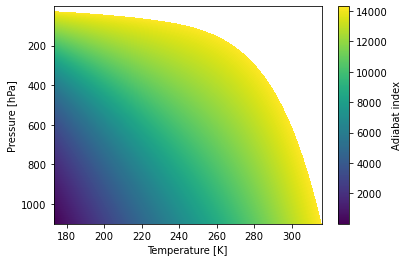

In [7]:
parcel.moist_adiabat_lookup.adiabat.plot(y='pressure', yincrease=False, 
                                         cbar_kwargs={'label': 'Adiabat index'})
plt.show()

Interpolation of the adiabats across the discrete pressure/temperature fields means that pressure/temperature combinations which do not have any associated adiabat (yellow in the plot below) are limited to areas outside reasonable temperature ranges.

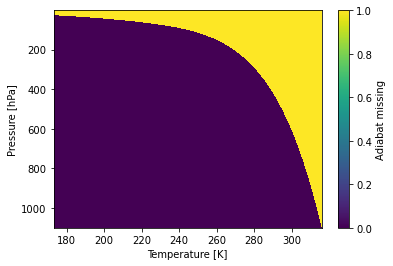

In [8]:
np.isnan(parcel.moist_adiabat_lookup.adiabat).plot(y='pressure', yincrease=False,
                                                   cbar_kwargs={'label': 'Adiabat missing'})
plt.show()

The following plot shows output from the xarray lookup table implementation and the metpy implementation for a starting parcel at 1000 hPa and a variety of starting parcel temperatures. The adiabats are indistinguishable on the Skew T plot yet there are small differences introduced by the lookup table approach; the maximum difference for these adiabats is reported below.

Maximum difference between metpy and xarray on these adiabats is 0.037 K.


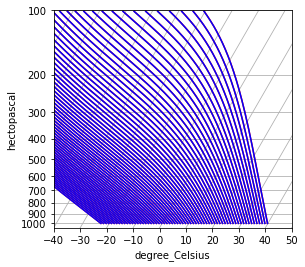

In [9]:
skew = metpy.plots.SkewT()
max_diff = 0
pressures = np.arange(1000, 100, step=-1)
for temperature in np.arange(250, 314, step=1):
    adiabat_xr = parcel.moist_lapse(pressure=pressures, parcel_pressure=1000, parcel_temperature=temperature)
    adiabat_mp = metpy.calc.moist_lapse(pressure=pressures*units.hPa, temperature=temperature*units.K, 
                                        reference_pressure=1000*units.hPa)
    max_diff = np.max([max_diff, np.round(np.max(np.abs(adiabat_xr.values - adiabat_mp.m)), 3)])
    skew.plot(pressures*units.hPa, adiabat_xr.values*units.K, 'r')
    skew.plot(pressures*units.hPa, adiabat_mp, 'b')
    
print(f'Maximum difference between metpy and xarray on these adiabats is {max_diff} K.')

# Testing

The following code takes a set of 225 data points and runs the xarray implementation (with virtual temperature correction turned off) and metpy implementations for a variety of functions. Any differences greater than a threshold of absolute difference of `1e-5` are reported. Note the maximum absolute difference and the maximum relative difference may be on different points. Wet bulb temperature is calculated an accurate but slow way, using lifted parcels, and using a faster 'one-third rule' as `wet_bulb_temperature_fast`, which is an approximation only so is expected to differ from the MetPy wet bulb temperature calculation. See [Knox et al., 2017](https://doi.org/10.1175/BAMS-D-16-0246.1) for details and calculations on the accuracy of this technique.

In [10]:
# Take a sample of points from dat.
num_points = 15
lat = np.random.randint(0, dat.latitude.size-num_points)
lon = np.random.randint(0, dat.longitude.size-num_points)
pts = dat.isel(latitude=slice(lat, lat+num_points), 
               longitude=slice(lon, lon+num_points))
pts = pts.chunk({'latitude': 1, 'longitude': 1, 'model_level_number': -1}).load()

In [11]:
reload(parcel)
reload(parcel_test)
xr, mp = parcel_test.test_parcel_functions(dat=pts, virt_temp=False, lcl_interp='linear', pos_cape_neg_cin=False)

Calculating xarray results...		4.467093488201499 s.
Calculating metpy serial results...	67.8654740927741 s.
Differences                                                       Max abs. diff        Max rel. diff       
Mixed parcel temperature [K] (mp_temperature)                     0.00012 K            0.0%                
Mixed-parcel dewpoint [kelvin] (mp_dewpoint)                      3e-05 kelvin         0.0%                
Moist lapse rate temperature [K] (moist_lapse_temp)               0.07562 K            0.1%                
Temperature at LCL [K] (surface_profile)                          0.07346 K            0.1%                
Level of free convection pressure [hPa] (surface_lfc_pressure)    1.78922 hPa          0.2%                
Lifting condensation level pressure [hPa] (surface_lcl_pressure)  0.00065 hPa          0.0%                
Lifting condensation level temperature [K] (surface_lcl_temp)     3e-05 K              0.0%                
Level of free convection tem

As outlined above, the new implementation of `moist_lapse` is slightly less accurate than MetPy's analytical function. These changes introduce some differences to the other calculations. To see testing results without this difference's impact, here are the tests again but this time using MetPy's approach to calculate moist lapse rates.

In [12]:
reload(parcel)
reload(parcel_test)

parcel.moist_lapse = parcel_test.moist_lapse_serial
_, _ = parcel_test.test_parcel_functions(dat=pts, virt_temp=False)

Calculating xarray results...		157.0361388651654 s.
Calculating metpy serial results...	70.98202701285481 s.
Differences                                                       Max abs. diff        Max rel. diff       
Mixed parcel temperature [K] (mp_temperature)                     0.00012 K            0.0%                
Mixed-parcel dewpoint [kelvin] (mp_dewpoint)                      3e-05 kelvin         0.0%                
Temperature at LCL [K] (surface_profile)                          5e-05 K              0.0%                
Level of free convection pressure [hPa] (surface_lfc_pressure)    0.00115 hPa          0.0%                
Lifting condensation level pressure [hPa] (surface_lcl_pressure)  0.00065 hPa          0.0%                
Lifting condensation level temperature [K] (surface_lcl_temp)     3e-05 K              0.0%                
Level of free convection temperature [K] (surface_lfc_temp)       5e-05 K              0.0%                
Equilibrium level pressure 

Another function in which small differences occur is `lcl`, which determines lifting condensation levels. In both cases the MetPy function is used, since it appears to work on multi-dimensional data. It is an iterative function, however, and the results when it is called with multi-dimensional input are slightly different to those when it called for single values. To see the test results without these differences, here are test results using MetPy's `moist_lapse` and MetPy's `lcl` on single points. The small differences in the other outputs give us some confidence in the accuracy of the other xarray parcel functions.

Note that it appears that MetPy's implementation of `lcl` is sensitive to the size of the arrays passed to it, presumably because they contain different maxima and minema. Only small changes are caused by these differences in the iterative approach, but they can translate into (slight) differences in functions that use the LCL (e.g. CAPE, CIN, lapse rates). In the latest implementation of `xarray_parcel`, `lcl` is called by chunk so changing the chunk size can change the results slightly.

In [13]:
reload(parcel)
reload(parcel_test)

parcel.moist_lapse = parcel_test.moist_lapse_serial
parcel.lcl = parcel_test.lcl_serial
_, _ = parcel_test.test_parcel_functions(dat=pts, virt_temp=False)

Calculating xarray results...		232.5873322505504 s.
Calculating metpy serial results...	70.45647970214486 s.
Differences                                                       Max abs. diff        Max rel. diff       
Mixed parcel temperature [K] (mp_temperature)                     0.00012 K            0.0%                
Mixed-parcel dewpoint [kelvin] (mp_dewpoint)                      3e-05 kelvin         0.0%                
Temperature at LCL [K] (surface_profile)                          3e-05 K              0.0%                
Level of free convection pressure [hPa] (surface_lfc_pressure)    0.00014 hPa          0.0%                
Level of free convection temperature [K] (surface_lfc_temp)       1e-05 K              0.0%                
Equilibrium level pressure [hPa] (surface_el_pressure)            2e-05 hPa            0.0%                
Equilibrium level temperature [K] (surface_el_temp)               1e-05 K              0.0%                
Convective available potent

Small differences in moist lapse rate results introduce larger differences in CAPE and CIN calculations. Because there are many assumptions made in the calculation of CAPE and CIN (e.g. which parcel to choose, how to interpolate profiles and define intersection points), these differences are acceptable.

## Differences under updated implementation

I have implemented several improvements on the MetPy implementation. These are:

- Use of the virtual temperature correction.
- Only counting positive buoyancy in CAPE calculations, and negative buoyancy in CIN calculations.
- Using interpolation on pressure coordinates in log space for the LCL calculation.

When these improvements are included, here are the differences on the same points, compared to the raw MetPy implementation.

In [14]:
reload(parcel)
reload(parcel_test)
xr, mp = parcel_test.test_parcel_functions(dat=pts, virt_temp=True, lcl_interp='log', pos_cape_neg_cin=True)

Calculating xarray results...		4.27530652564019 s.
Calculating metpy serial results...	70.4108678996563 s.
Differences                                                       Max abs. diff        Max rel. diff       
Mixed parcel temperature [K] (mp_temperature)                     0.00012 K            0.0%                
Mixed-parcel dewpoint [kelvin] (mp_dewpoint)                      3e-05 kelvin         0.0%                
Moist lapse rate temperature [K] (moist_lapse_temp)               0.07562 K            0.1%                
Temperature at LCL [K] (surface_profile)                          0.07346 K            0.1%                
Level of free convection pressure [hPa] (surface_lfc_pressure)    1.78922 hPa          0.2%                
Lifting condensation level pressure [hPa] (surface_lcl_pressure)  0.00065 hPa          0.0%                
Lifting condensation level temperature [K] (surface_lcl_temp)     3e-05 K              0.0%                
Level of free convection temp

# Unit tests

Here we check that the xarray implementation passes all relevant unit tests from MetPy, as long as the MetPy version of `moist_lapse` is used. If so this means that the logic in all the functions (other than `moist_lapse`) is correct.

**NOTE** that in MetPy CAPE and CIN calculations, all differences between the parcel and environment temperatures are included, meaning that CIN can go positive and CAPE can go negative if there are multiple positive/negative regions over the integrated range. This is non-standard so in xarray_parcel, only positive areas are counted for CAPE and only negative areas are counted for CIN.

In [15]:
reload(parcel)
reload(parcel_test)
reload(tests)

<module 'modules.unit_tests' from '/home/561/tr2908/git/xarray_parcel/modules/unit_tests.py'>

In [16]:
parcel.load_moist_adiabat_lookups()
parcel.moist_lapse = tests.metpy_moist_lapse
tests.run_all_tests()

All tests passed.


Now we check that the unit tests for `moist_lapse` pass using the lookup table implementation, if `test_moist_lapse_uniform`'s required accuracy is changed from from 7 decimal places to 2 decimal places. The other unit tests do not all pass when the lookup table is used, because small changes in moist lapse rates have effects on profile and CAPE/CIN calculations.

In [17]:
reload(parcel)
parcel.load_moist_adiabat_lookups()
tests.run_moist_lapse_tests_looser()

Moist lapse tests passed.


## Log interpolation of LCL environment

MetPy uses linear interpolation on pressure levels to get the environmental temperature at the LCL. I have updated my code to use logarithmic interpolation by default. Here are the differences that change makes on convective properties for the random points from the testing data used above.

In [18]:
xr_log = parcel_test.conv_properties_xarray(dat=pts, virt_temp=False, lcl_interp='log')
parcel_test.compare_results(set1=xr, set2=xr_log)

Differences                                                       Max abs. diff        Max rel. diff       
Convective available potential energy [J kg$^{-1}$] (mixed_cape)  264.1705 J kg$^{-1}$ 13.49%              
Convective inhibition [J kg$^{-1}$] (mixed_cin)                   65.43854 J kg$^{-1}$ -6.62%              
Convective available potential energy [J kg$^{-1}$] (max_cape)    325.65056 J kg$^{-1}$ 9.56%               
Convective inhibition [J kg$^{-1}$] (max_cin)                     8.58391 J kg$^{-1}$  -46.65%             
Level of free convection pressure [hPa] (lfc_pressure)            35.4821 hPa          3.92%               
Level of free convection temperature [K] (lfc_temperature)        4.96149 K            1.68%               
Equilibrium level pressure [hPa] (el_pressure)                    0.00223 hPa          0.0%                
Equilibrium level temperature [K] (el_temperature)                0.00035 K            0.0%                
Convective available potent

## Virtual temperature correction

MetPy does not correct for virtual temperature in buoyancy calculations as advised by [Doswell & Rasmussen 1994](https://doi.org/10.1175/1520-0434(1994)009%3C0625:TEONTV%3E2.0.CO;2). I have updated my parcel code so that by default it uses virtual temperatures in calculation of the LFC, EL, CAPE and CIN (note, not for LCL since [this should use real temperature](http://www.flame.org/~cdoswell/virtual/virtual.html).

In [19]:
reload(parcel)
parcel.load_moist_adiabat_lookups()

Finally, we show the differences in the results of the above xarray/serial comparison when the virtual temperature correction is used. 

In [20]:
xr = parcel_test.conv_properties_xarray(dat=pts, virt_temp=False, lcl_interp='linear')
xr_vt = parcel_test.conv_properties_xarray(dat=pts, virt_temp=True, lcl_interp='linear')
parcel_test.compare_results(set1=xr, set2=xr_vt)

Differences                                                       Max abs. diff        Max rel. diff       
Convective available potential energy [J kg$^{-1}$] (mixed_cape)  259.94288 J kg$^{-1}$ 11.3%               
Convective inhibition [J kg$^{-1}$] (mixed_cin)                   65.47271 J kg$^{-1}$ -7.67%              
Convective available potential energy [J kg$^{-1}$] (max_cape)    325.65069 J kg$^{-1}$ 8.72%               
Convective inhibition [J kg$^{-1}$] (max_cin)                     9.6361 J kg$^{-1}$   29604.89%           
Level of free convection pressure [hPa] (lfc_pressure)            35.4821 hPa          3.77%               
Level of free convection temperature [K] (lfc_temperature)        4.96149 K            1.65%               
Equilibrium level pressure [hPa] (el_pressure)                    0.00223 hPa          0.0%                
Equilibrium level temperature [K] (el_temperature)                0.00035 K            0.0%                
Convective available poten

CAPE is increased marginally by the virtual temperature correction.

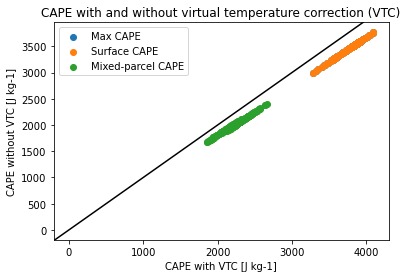

In [21]:
plt.scatter(xr_vt.max_cape.values, xr.max_cape.values, label='Max CAPE')
plt.scatter(xr_vt.surface_cape.values, xr.surface_cape.values, label='Surface CAPE')
plt.scatter(xr_vt.mixed_cape.values, xr.mixed_cape.values, label='Mixed-parcel CAPE')
plt.axline((0,0), (1,1), color='black')
plt.title('CAPE with and without virtual temperature correction (VTC)')
plt.legend()
plt.xlabel('CAPE with VTC [J kg-1]')
plt.ylabel('CAPE without VTC [J kg-1]')
plt.show()

As expected from [Doswell & Rasmussen 1994](https://doi.org/10.1175/1520-0434(1994)009%3C0625:TEONTV%3E2.0.CO;2) the relative change in CAPE is highest for smaller values of CAPE. Relative differences range from about 8% to 12% of the corrected value.

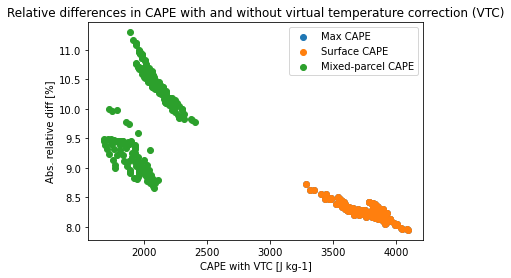

In [22]:
plt.scatter(xr_vt.max_cape.values, np.abs((xr.max_cape.values - xr_vt.max_cape.values) / 
                                          xr_vt.max_cape.values)*100, label='Max CAPE')
plt.scatter(xr_vt.surface_cape.values, np.abs((xr.surface_cape.values - xr_vt.surface_cape.values) / 
                                              xr_vt.surface_cape.values)*100, label='Surface CAPE')
plt.scatter(xr.mixed_cape.values, np.abs((xr.mixed_cape.values - xr_vt.mixed_cape.values) /
                                         xr_vt.mixed_cape.values)*100, label='Mixed-parcel CAPE')
plt.title('Relative differences in CAPE with and without virtual temperature correction (VTC)')
plt.legend()
plt.xlabel('CAPE with VTC [J kg-1]')
plt.ylabel('Abs. relative diff [%]')
plt.show()

The virtual temperature correction changes the LFC but not the LCL. Changes to CIN are are relatively larger than those to CAPE (relative changes are not shown here since relative changes become very large on small-magnitude CIN values).

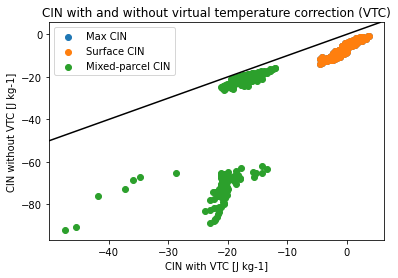

In [23]:
plt.scatter(xr_vt.max_cin.values, xr.max_cin.values, label='Max CIN')
plt.scatter(xr_vt.surface_cin.values, xr.surface_cin.values, label='Surface CIN')
plt.scatter(xr_vt.mixed_cin.values, xr.mixed_cin.values, label='Mixed-parcel CIN')
plt.axline((0,0), (1,1), color='black')
plt.title('CIN with and without virtual temperature correction (VTC)')
plt.legend()
plt.xlabel('CIN with VTC [J kg-1]')
plt.ylabel('CIN without VTC [J kg-1]')
plt.show()

# Benchmark for surface-based CAPE and CIN calculation

Here we benchmark the xarray implementation against the serial MetPy implementation.

In [24]:
reload(parcel)
reload(parcel_test)
benchmark_results = parcel_test.benchmark_cape(dat)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered 

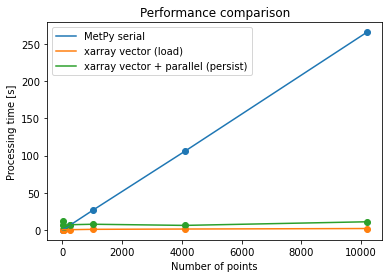

In [25]:
plt.scatter(benchmark_results.pts.values, benchmark_results.serial.values)
plt.scatter(benchmark_results.pts.values, benchmark_results.xr_load.values)
plt.scatter(benchmark_results.pts.values, benchmark_results.xr_persist.values)
plt.plot(benchmark_results.pts.values, benchmark_results.serial.values, label='MetPy serial')
plt.plot(benchmark_results.pts.values, benchmark_results.xr_load.values, label='xarray vector (load)')
plt.plot(benchmark_results.pts.values, benchmark_results.xr_persist.values, label='xarray vector + parallel (persist)')
plt.xlabel('Number of points')
plt.ylabel('Processing time [s]')
plt.title('Performance comparison')
plt.legend()
plt.show()

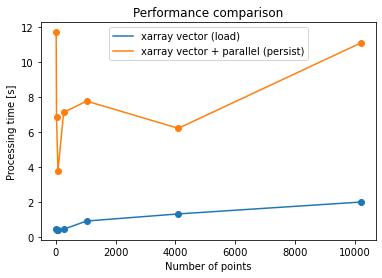

In [26]:
plt.scatter(benchmark_results.pts.values, benchmark_results.xr_load.values)
plt.scatter(benchmark_results.pts.values, benchmark_results.xr_persist.values)
plt.plot(benchmark_results.pts.values, benchmark_results.xr_load.values, label='xarray vector (load)')
plt.plot(benchmark_results.pts.values, benchmark_results.xr_persist.values, label='xarray vector + parallel (persist)')
plt.xlabel('Number of points')
plt.ylabel('Processing time [s]')
plt.title('Performance comparison')
plt.legend()
plt.show()

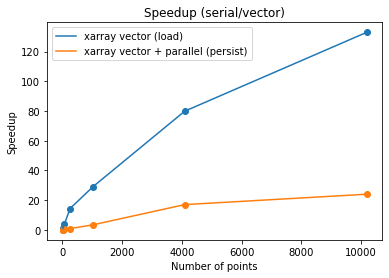

In [27]:
plt.scatter(benchmark_results.pts.values, (benchmark_results.serial.values/
                                           benchmark_results.xr_load.values))
plt.scatter(benchmark_results.pts.values, (benchmark_results.serial.values/
                                           benchmark_results.xr_persist.values))
plt.plot(benchmark_results.pts.values, (benchmark_results.serial.values/
                                        benchmark_results.xr_load.values), label='xarray vector (load)')
plt.plot(benchmark_results.pts.values, (benchmark_results.serial.values/
                                        benchmark_results.xr_persist.values), label='xarray vector + parallel (persist)')

plt.xlabel('Number of points')
plt.ylabel('Speedup')
plt.title('Speedup (serial/vector)')
plt.legend()
plt.show()